## Problem Statement
For each month end date, create a portfolio of stocks by following rules:
1.  Select most liquid 250 names based on past 6 months. (Liquidity is given by price multiplied volume)
2. From 250 names select the stocks which have seen minimum of maximum 1-year drawdown. Drawdown is defined as peak-to-trough decline during a specific period (here last 1-year). So for each stock there will be maximum and minimum price point in last 1 year. The ratio of minimum price to maximum price will give maximum drawdown for that stocks. From the universe of 250 stocks selected on liquidity, select top 100 which have seen minimum of maximum drawdown.

3. From the selected 100 names, select 20 stocks with maximum return in last 1 month to get the required portfolio, which changes every month
4. Create NAV series from the selected portfolio assuming equal amount in each stocks. So at 1st portfolio assume 100 crores distributed in 20 stocks: - 5 crores in each. Based on returns of stocks in portfolio, 100 crores will maybe grow into 110 crores next month (or declined to 98 crores maybe). In the next month redistribute the 110 crores (or 98 crores depending on returns) equally into 2nd portfolio and then it grows into maybe 121 crores, redistribute that equally into 3rd portfolio and so on. The series of 100, 110, 121 etc. is the net asset value or NAV series.
5. From Market Cap file we have market capitalisation on each date as well. For each date sort stocks on highest to lowest market cap. Large Cap stocks are stocks which are in largest 100 stocks by market cap, Mid Cap are those which are in 100-250 and Small Cap are those having market capitalisation below market cap of top 250 stocks. Let’s say out of 20 stocks in selected portfolio 8 names are in top 100, 7 in 100 to 250 and 5 below 250. So 40% of portfolio is in Large cap, 35% in Mid cap and 25% in Small Cap.

In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np

# Importing Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
price = pd.read_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Price Data.csv')
volume = pd.read_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Volume Data.csv')
market_cap = pd.read_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Market Cap Data.csv')

In [ ]:
def check_missing_drop(data_matrix):
  # Check for missing values in datasets
  null_col = data_matrix.isnull().sum()
  # set threshold of 60%
  drop_cols = null_col[null_col > len(data_matrix)*0.60]
  # dropping columns having highy missing values more than 60%
  data_matrix_new = data_matrix.drop(list(drop_cols.index), axis=1)
  return data_matrix_new,drop_cols

In [ ]:
## Dropping columns having more than 70%

price_1, price_col_drop = check_missing_drop(price)  # (272, 1229), (272, 955)
volume_1, vol_col_drop = check_missing_drop(volume) #(272, 1229), (272, 947)
market_cap_1, mc_col_drop = check_missing_drop(market_cap) # (272, 1229), (272, 1229)

In [ ]:
# Keeping the columns of volumn columns to maintain high uniformity

price_1 = price.drop(list(vol_col_drop.index), axis=1)
volume_1 = volume.drop(list(vol_col_drop.index), axis=1)
market_cap_1 = market_cap.drop(list(vol_col_drop.index), axis=1)

In [ ]:
price_1.shape,volume_1.shape,market_cap_1.shape

((272, 1019), (272, 1019), (272, 1019))

In [ ]:
price =price_1
market_cap =market_cap_1
volume1=volume_1.drop(["Dates"], axis=1)
liquidity = price.loc[:, price.columns != 'Dates']* volume1.values  # calculating liquidity

In [ ]:
liquidity = liquidity.set_index(volume['Dates'])

# Finding Top 250 Liquidity Stocks

### Rank - Function

In [ ]:
# Finding Ranks in Descending Order from High to Low
def rank(n,df):
  nlargest = n
  order = np.argsort(-df.values, axis=1)[:, :nlargest]
  ranks = pd.DataFrame(df.columns[order],
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=liquidity.index)
  return ranks

In [ ]:
liquidity_old = price.loc[:, price.columns != 'Dates']* volume1.values

In [ ]:
# Finding Average Liquidity based on past 6 months
for i in liquidity.columns:
  liquidity[i] = liquidity[i].rolling(6).mean()

  #https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

In [ ]:
New_Ranks= rank(250,liquidity)  # for ranks after rolling
Old_Ranks= rank(250,liquidity_old) # for ranks before rolling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


In [ ]:
Old_Ranks = Old_Ranks.set_index(volume['Dates']) # setting Index
New_Ranks = New_Ranks.set_index(volume['Dates']) # Setting Index

In [ ]:
# Saving Liquidity and Ranks to CSV

New_Ranks.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Col_drop/New_Ranks_250.csv')
liquidity.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Col_drop/liquidity_new_after_rolling.csv')


In [ ]:
# Creating a dummy dataframe to store the liquidity values of top 250 stocks on each month end date
New_Ranks_dummy = pd.DataFrame(np.nan, index= New_Ranks.index, columns = New_Ranks.columns)

### Function for fetching values

In [ ]:
# Function to fetch values from different dataset

def fetch_values(from_df,to_df,blank_df):
  ranks = blank_df
  for i_rr,row_rr in to_df.iterrows():
    for col_rr in to_df.columns:
      y_rr = to_df.loc[i_rr,col_rr]
      j_rr = from_df.loc[i_rr,y_rr]
      ranks.loc[i_rr,col_rr] = j_rr
  return ranks


In [ ]:
# retrieving top_250 liquidity values based on ranks
top_250_liquidity_values = fetch_values(liquidity,New_Ranks,New_Ranks_dummy)
top_250_liquidity_values.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Col_drop/top_250_liquidity_values.csv')

# Finding Lowest 100 Stocks having min maximum of 1 -year drawdown

In [ ]:
volume1 = volume1.set_index(New_Ranks.index)
max_drawdown = pd.DataFrame()
price1=price.drop(["Dates"], axis=1)

In [ ]:
# Finding max_drawdown based on ratio of min to max (10)

for i in price1.columns:
  max_drawdown[i] = price1[i].rolling(12).min()/price1[i].rolling(12).max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [ ]:
max_drawdown = max_drawdown.set_index(New_Ranks.index)

In [ ]:
top_250_max_drawdown_values = pd.DataFrame(np.nan, index = New_Ranks.index, columns = New_Ranks.columns)

In [ ]:
# fetchingvalues of maxdrawdown for top 250 liquid stocks
for i,row in New_Ranks.iterrows():
  for col in New_Ranks.columns:
    y = New_Ranks.loc[i,col]
    j = max_drawdown.loc[i,y]
    top_250_max_drawdown_values.loc[i,col] = j

In [ ]:
max_drawdown.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/max_drawdown.csv')
top_250_max_drawdown_values.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/top_250_max_draw_values.csv')

In [ ]:
#finding Lowest 100 max_drawdon stocks in ascending order
nlargest = 100
order = np.argsort(top_250_max_drawdown_values.values, axis=1)[:, :nlargest]
min_100_ranks = pd.DataFrame(top_250_max_drawdown_values.columns[order],
                      columns=['Low{}'.format(i) for i in range(1, nlargest+1)],
                      index=top_250_max_drawdown_values.index)
min_100_ranks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


,Low1,Low2,Low3,Low4,Low5,Low6,Low7,Low8,Low9,Low10,...,Low91,Low92,Low93,Low94,Low95,Low96,Low97,Low98,Low99,Low100
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-31,top1,top159,top160,top161,top162,top163,top164,top165,top166,top167,...,top221,top220,top219,top218,top190,top191,top192,top193,top194,top195
2000-02-29,top1,top159,top160,top161,top162,top163,top164,top165,top166,top167,...,top221,top220,top219,top218,top190,top191,top192,top193,top194,top195
2000-03-31,top1,top159,top160,top161,top162,top163,top164,top165,top166,top167,...,top221,top220,top219,top218,top190,top191,top192,top193,top194,top195
2000-04-28,top1,top159,top160,top161,top162,top163,top164,top165,top166,top167,...,top221,top220,top219,top218,top190,top191,top192,top193,top194,top195
2000-05-31,top1,top159,top160,top161,top162,top163,top164,top165,top166,top167,...,top221,top220,top219,top218,top190,top191,top192,top193,top194,top195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,top147,top131,top171,top125,top233,top107,top209,top199,top15,top206,...,top128,top47,top31,top99,top154,top104,top241,top38,top219,top224
2022-05-31,top168,top155,top182,top146,top7,top189,top154,top190,top96,top31,...,top73,top188,top134,top220,top97,top102,top9,top110,top212,top29
2022-06-30,top201,top151,top171,top7,top156,top221,top146,top75,top126,top97,...,top103,top162,top194,top14,top164,top110,top49,top29,top130,top178


In [ ]:
# Save CSV
min_100_ranks.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/min_100_ranks_after_drawdown.csv')

In [ ]:
min_100_dummy_1= pd.DataFrame(np.nan, index= min_100_ranks.index, columns = min_100_ranks.columns)
min_100_names_ranks = fetch_values(New_Ranks,min_100_ranks,min_100_dummy_1)

In [ ]:
min_100_dummy = pd.DataFrame(np.nan, index= min_100_ranks.index, columns = min_100_ranks.columns)  # dummy  for storing variable
min_100_values = fetch_values(max_drawdown,min_100_names_ranks,min_100_dummy)


In [ ]:
min_100_values.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/min_100_values_after_drawdown.csv')

# Top 20 Stocks having Higher returns

In [ ]:
high_returns_for_100= pd.DataFrame(np.nan, index = min_100_names_ranks.index, columns = min_100_names_ranks.columns)  # Monthly returns for all 100 stocks
high_returns = pd.DataFrame(np.nan, index = min_100_names_ranks.index, columns = min_100_names_ranks.columns)  # Monthly returns for all 100 stocks

In [ ]:
price2 = price.set_index(price1.index)

In [ ]:
price2 = price2.drop('Dates',axis=1)

In [ ]:
# calculating Monthly returns in % change
monthly_returns =(price2.pct_change(periods=1))*100
monthly_returns = monthly_returns.set_index(min_100_ranks.index)

In [ ]:
fetch_values(monthly_returns,min_100_names_ranks,high_returns)

,Low1,Low2,Low3,Low4,Low5,Low6,Low7,Low8,Low9,Low10,...,Low91,Low92,Low93,Low94,Low95,Low96,Low97,Low98,Low99,Low100
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,-28.248588,-11.102662,NaN,-1.327434,NaN,33.088235,-11.333819,-2.971768,-4.222222,NaN,...,-3.177570,-7.218095,-1.019417,0.000000,-5.298171,NaN,NaN,NaN,-18.444080,-20.465394
2000-03-31,3.937008,-19.846022,NaN,0.000000,NaN,-31.215470,-12.946979,-6.891271,-23.201856,NaN,...,-33.204633,-33.640057,-11.549779,0.000000,-32.940291,NaN,NaN,NaN,-37.116513,-1.050263
2000-04-28,0.000000,-14.140875,NaN,-6.278027,NaN,-42.168675,-27.903683,-15.213816,-7.284324,NaN,...,-18.786127,-2.611201,-3.548655,-11.494253,-15.937149,NaN,NaN,NaN,-26.312983,-14.480667
2000-05-31,12.878788,9.011809,NaN,-3.349282,NaN,1.388889,-39.685658,10.184287,9.196235,NaN,...,0.000000,-11.593935,0.862317,0.000000,-6.008011,NaN,NaN,NaN,-19.392185,-0.088652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-14.805726,-16.196761,-10.986367,-2.251656,51.123596,-7.608171,5.112141,-1.137769,51.458671,-1.502414,...,-9.460564,-2.105066,-3.073745,-5.559628,2.171429,-5.909242,-4.833729,1.351861,3.161013,11.884936
2022-05-31,-23.571771,-10.236220,-9.729730,-8.536585,15.302301,11.008256,-17.015419,0.714337,-19.551793,1.052632,...,-5.018995,-12.074084,-8.980044,-6.551828,-0.844044,-8.006992,-12.451386,-1.980894,-1.080350,-10.467149
2022-06-30,-28.443114,-3.429027,-51.162060,-18.685228,11.502364,-18.878307,-12.793630,-19.703390,-18.895542,-14.111214,...,-12.625530,8.312265,-4.358714,-13.428514,5.472080,-11.104241,-7.024500,0.196304,-14.591899,-5.955620


In [ ]:
# Finding top 20 stocks in terms of Monthly Returns
nlargest = 20
order = np.argsort(-high_returns.values, axis=1)[:, :nlargest]
ttop_20_ranks = pd.DataFrame(high_returns.columns[order],
                      columns=['Top{}'.format(i) for i in range(1, nlargest+1)],
                      index=monthly_returns.index)
ttop_20_ranks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20
Dates,,,,,,,,,,,,,,,,,,,,
2000-01-31,Low1,Low73,Low72,Low71,Low70,Low69,Low68,Low67,Low66,Low65,Low64,Low63,Low62,Low61,Low60,Low59,Low58,Low57,Low56,Low55
2000-02-29,Low25,Low73,Low61,Low38,Low37,Low18,Low32,Low86,Low6,Low21,Low23,Low35,Low57,Low90,Low48,Low71,Low54,Low36,Low89,Low64
2000-03-31,Low40,Low56,Low59,Low48,Low71,Low90,Low35,Low53,Low36,Low1,Low21,Low46,Low4,Low94,Low20,Low18,Low84,Low100,Low32,Low37
2000-04-28,Low62,Low25,Low53,Low68,Low40,Low56,Low28,Low60,Low55,Low57,Low46,Low24,Low21,Low20,Low18,Low1,Low90,Low75,Low88,Low11
2000-05-31,Low18,Low78,Low76,Low45,Low65,Low56,Low59,Low1,Low90,Low8,Low9,Low2,Low35,Low81,Low80,Low38,Low23,Low27,Low53,Low6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,Low11,Low54,Low9,Low5,Low12,Low72,Low28,Low67,Low80,Low24,Low13,Low100,Low45,Low76,Low16,Low65,Low31,Low18,Low88,Low49
2022-05-31,Low12,Low5,Low6,Low38,Low31,Low25,Low48,Low84,Low13,Low70,Low50,Low43,Low34,Low23,Low52,Low10,Low74,Low36,Low8,Low61
2022-06-30,Low87,Low18,Low5,Low92,Low45,Low21,Low95,Low60,Low84,Low54,Low27,Low80,Low67,Low98,Low64,Low70,Low13,Low20,Low39,Low47


In [ ]:
Top_20_rank_names = pd.DataFrame(np.nan, index= ttop_20_ranks.index, columns = ttop_20_ranks.columns)
fetch_values(min_100_names_ranks,ttop_20_ranks,Top_20_rank_names)
Top_20_rank_values= pd.DataFrame(np.nan, index= ttop_20_ranks.index, columns = ttop_20_ranks.columns)  # dummy  for storing variable
fetch_values(monthly_returns,Top_20_rank_names,Top_20_rank_values)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20
Dates,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,83.253589,75.726539,60.000000,52.728298,48.641975,38.461538,37.546773,36.666667,33.088235,25.509419,21.172638,17.679558,15.902778,14.010562,11.717496,7.354103,5.911330,4.041008,3.656559,2.531646
2000-03-31,32.132353,21.882378,20.279720,15.325670,11.455759,10.272480,9.389671,6.213873,4.068813,3.937008,2.084071,0.000000,0.000000,0.000000,0.000000,0.000000,-0.484914,-1.050263,-2.796906,-3.227337
2000-04-28,46.254459,44.383562,12.653061,9.845077,8.080134,7.184996,6.565599,3.916449,3.896104,0.252313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785340
2000-05-31,144.444444,32.031250,31.859171,22.918919,20.099256,17.308798,17.303609,12.878788,12.849024,10.184287,9.196235,9.011809,8.888889,8.333333,7.613169,5.930492,3.610108,2.968750,2.053140,1.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,118.768745,77.283654,51.458671,51.123596,42.156585,22.670409,19.760852,15.746640,13.165426,12.728411,12.722138,11.884936,11.709272,11.225398,10.869737,10.189503,9.289617,8.823529,8.398662,7.548200
2022-05-31,18.164362,15.302301,11.008256,10.197990,10.033898,8.199046,7.454233,7.321280,4.601873,4.376938,2.410537,1.943307,1.894248,1.523856,1.359689,1.052632,0.929615,0.829539,0.714337,0.458899
2022-06-30,14.309959,11.645102,11.502364,8.312265,8.035868,7.338480,5.472080,5.088558,4.994609,2.955420,1.542745,1.077249,0.983118,0.196304,0.093342,-0.439016,-0.541353,-1.066098,-1.205309,-1.237841


In [ ]:
top_20_ranks_names = ttop_20_ranks

In [ ]:
ttop_20_ranks_vall = ttop_20_ranks  # dummy for fetching values
top_20_ranks_names.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/top_20_ranks_names.csv')
monthly_returns.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/monthly_returns_values.csv')

In [ ]:
Top_20_rank_values.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/top_20_ranks_values.csv')

In [ ]:
top_20_returns_values =Top_20_rank_values

# Creating NAV Series

In [ ]:
returns = top_20_returns_values/100  # conevrted for calculations of NAV amount

In [ ]:
final_amount = pd.DataFrame(columns=returns.columns, index =returns.index ) # for calculating final amount
NAV_value = [] # blank list

In [ ]:
initial_amount = 10**9  # initial 100 Crs into stocks
for i, j in returns.iterrows():
  individual = initial_amount / 20
  final_amount.loc[i]= individual * returns.loc[i]
  row_sum = final_amount.loc[i].sum(axis=0)
  NAV_value.append(row_sum)
  initial_amount == row_sum

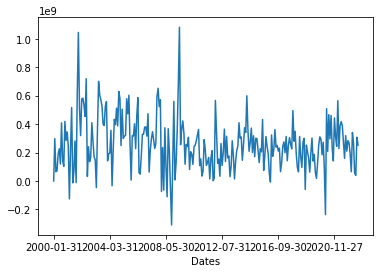

In [ ]:
# Plotting NAV Values
NAV_data = pd.DataFrame(NAV_value,columns=['Month_End_Sum'], index =returns.index)  #
import matplotlib.pyplot as plt
%matplotlib inline

# Plot adjusted close price data
NAV_data['Month_End_Sum'].plot()
plt.show()

In [ ]:
NAV_data.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/monthly_NAV_values.csv')
final_amount.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Stockwise_NAV_returns_values.csv')

In [ ]:
market_cap_new = market_cap_1

In [ ]:
market_cap_new_new = market_cap_new.drop('Dates', axis=1)  # dropping dates for calculation

In [ ]:
market_cap_new = market_cap_new.set_index(returns.index)

In [ ]:
market_cap_new_new


,1909315D IN Equity,3M IN Equity,63MOONS IN Equity,A2ZL IN Equity,AACL IN Equity,ABAN IN Equity,ABB IN Equity,ABFRL IN Equity,ABGS IN Equity,ABNL IN Equity,...,RMKY IN Equity,RUPA IN Equity,SLCL IN Equity,SPII IN Equity,SRIK IN Equity,SUF IN Equity,TWO IN Equity,VISP IN Equity,WHL IN Equity,ZDC IN Equity
0,897.1410,6995.5652,4704.6461,NaN,NaN,177.3817,10936.4227,NaN,NaN,7873.4624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505.5570
1,643.8306,5844.2822,4879.7443,NaN,NaN,150.6960,11597.0398,NaN,NaN,5789.9556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397.3203
2,668.4580,5339.6102,5908.6061,NaN,NaN,132.4869,8904.8698,NaN,NaN,4824.9630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.5046
3,696.6036,4871.5494,2565.1249,NaN,NaN,106.7430,6794.6228,NaN,NaN,4101.2186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.1808
4,668.4580,5632.5002,2658.4254,NaN,NaN,125.5800,7867.3490,NaN,NaN,3478.8536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.7785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,NaN,224902.0533,10181.0528,2395.2301,162389.9525,3539.8568,444276.5036,267863.4922,NaN,NaN,...,14735.6696,42000.8964,NaN,305.8106,NaN,223513.1904,20023.6608,556.1310,15070.4294,3051.6122
268,NaN,227484.5706,8386.2937,2183.8862,139415.0122,2883.2470,514354.6032,254544.4751,NaN,NaN,...,12057.7151,30104.0222,NaN,304.5257,NaN,180704.8731,18893.7144,468.3209,14528.9769,2337.2997
269,NaN,246187.4030,7720.4589,1761.1986,128631.6580,2585.5838,487579.9800,222423.1066,NaN,NaN,...,10289.7115,27583.0936,NaN,314.8051,NaN,195726.1150,17924.0688,409.7807,15268.9621,2047.6132
270,NaN,256199.2340,8374.7741,2095.8263,149686.6522,2617.6847,579813.0975,252076.2672,NaN,NaN,...,10895.1922,29535.4216,NaN,468.9953,NaN,227462.9326,17649.6408,380.5107,17420.3335,2311.3022


In [ ]:
mc_ranks= rank(len(market_cap_new_new.columns),market_cap_new_new)  # ranked each stock from high to low market cap values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


In [ ]:
mc_ranks

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top1009,top1010,top1011,top1012,top1013,top1014,top1015,top1016,top1017,top1018
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-31,WPRO IN Equity,HUVR IN Equity,INFO IN Equity,RIL IN Equity,ONGC IN Equity,Z IN Equity,IOCL IN Equity,TCOM IN Equity,MTNL IN Equity,ITC IN Equity,...,DIVI IN Equity,DITV IN Equity,DISH IN Equity,MRGC IN Equity,MRKS IN Equity,DIGV IN Equity,MRLI IN Equity,MRLN IN Equity,MPS IN Equity,KOEL IN Equity
2000-02-29,WPRO IN Equity,HUVR IN Equity,INFO IN Equity,RIL IN Equity,SCS IN Equity,Z IN Equity,ONGC IN Equity,TCOM IN Equity,ITC IN Equity,MTNL IN Equity,...,MROTK IN Equity,ECLX IN Equity,MSIL IN Equity,DYTC IN Equity,MTCL IN Equity,MTLM IN Equity,DSK IN Equity,MUS IN Equity,EDA IN Equity,KOEL IN Equity
2000-03-31,WPRO IN Equity,INFO IN Equity,HUVR IN Equity,RIL IN Equity,SCS IN Equity,ONGC IN Equity,Z IN Equity,ITC IN Equity,TCOM IN Equity,MTNL IN Equity,...,EDC IN Equity,EDA IN Equity,MTCL IN Equity,MTLM IN Equity,ECLX IN Equity,DYTC IN Equity,MUS IN Equity,MUTH IN Equity,MSIL IN Equity,KOEL IN Equity
2000-04-28,WPRO IN Equity,INFO IN Equity,HUVR IN Equity,RIL IN Equity,SCS IN Equity,ONGC IN Equity,MTNL IN Equity,ITC IN Equity,Z IN Equity,TCOM IN Equity,...,EDC IN Equity,MSIL IN Equity,ECLX IN Equity,MTCL IN Equity,MTLM IN Equity,DYTC IN Equity,MUS IN Equity,MUTH IN Equity,EDA IN Equity,KOEL IN Equity
2000-05-31,HUVR IN Equity,INFO IN Equity,WPRO IN Equity,RIL IN Equity,Z IN Equity,ONGC IN Equity,ITC IN Equity,HCLT IN Equity,SCS IN Equity,TCOM IN Equity,...,NSE IN Equity,EXCC IN Equity,NJCC IN Equity,EVI IN Equity,NMDC IN Equity,NML IN Equity,EROS IN Equity,ERIE IN Equity,NITCO IN Equity,KOEL IN Equity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,RIL IN Equity,TCS IN Equity,HDFCB IN Equity,INFO IN Equity,HUVR IN Equity,ICICIBC IN Equity,SBIN IN Equity,BHARTI IN Equity,HDFC IN Equity,BAF IN Equity,...,KARG IN Equity,JSWI IN Equity,JPO IN Equity,SUSL IN Equity,SVOG IN Equity,JCPL IN Equity,IVRC IN Equity,IS IN Equity,STAN IN Equity,1909315D IN Equity
2022-05-31,RIL IN Equity,TCS IN Equity,HDFCB IN Equity,INFO IN Equity,HUVR IN Equity,ICICIBC IN Equity,HDFC IN Equity,SBIN IN Equity,BHARTI IN Equity,BAF IN Equity,...,KOPD IN Equity,KLGS IN Equity,SUSL IN Equity,SVOG IN Equity,KARG IN Equity,JSWI IN Equity,JPO IN Equity,JCPL IN Equity,STLC IN Equity,1909315D IN Equity
2022-06-30,RIL IN Equity,TCS IN Equity,HDFCB IN Equity,INFO IN Equity,HUVR IN Equity,ICICIBC IN Equity,SBIN IN Equity,HDFC IN Equity,BHARTI IN Equity,ITC IN Equity,...,JSWI IN Equity,JPO IN Equity,JCPL IN Equity,IVRC IN Equity,IS IN Equity,TATASTL IN Equity,IOLB IN Equity,PSI IN Equity,SUSL IN Equity,1909315D IN Equity


In [ ]:
mc_ranks.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Sorted_ranks_MC_stock_names.csv')

In [ ]:
market_cap_ranks_values = pd.DataFrame(index= mc_ranks.index)  # dummy for market cap values

In [ ]:
fetch_values(market_cap_new,mc_ranks,market_cap_ranks_values)  # fetching values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top1009,top1010,top1011,top1012,top1013,top1014,top1015,top1016,top1017,top1018
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-31,9.108911e+05,5.354190e+05,4.765387e+05,3.072034e+05,3.005869e+05,2.261739e+05,1.963816e+05,1.767000e+05,1.731555e+05,1.711156e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,1.512423e+06,6.367501e+05,5.757222e+05,2.908161e+05,2.627919e+05,2.440897e+05,2.346374e+05,2.118595e+05,1.835704e+05,1.794870e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,1.258783e+06,5.887750e+05,5.357484e+05,2.936641e+05,2.304607e+05,1.934279e+05,1.908278e+05,1.803800e+05,1.748000e+05,1.480500e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-28,7.632351e+05,5.357340e+05,5.270205e+05,3.239175e+05,1.754626e+05,1.568527e+05,1.417815e+05,1.398865e+05,1.325712e+05,1.263500e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,5.644513e+05,4.623955e+05,4.246242e+05,3.621763e+05,2.007720e+05,1.816640e+05,1.776805e+05,1.723570e+05,1.429457e+05,1.211250e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,1.887692e+07,1.297756e+07,7.679697e+06,6.594407e+06,5.250984e+06,5.165887e+06,4.429285e+06,4.193143e+06,4.042498e+06,4.039056e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-31,1.781087e+07,1.231033e+07,7.710436e+06,6.326313e+06,5.529176e+06,5.234582e+06,4.184980e+06,4.177611e+06,3.975698e+06,3.682086e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,1.756082e+07,1.195449e+07,7.487537e+06,6.150863e+06,5.240998e+06,4.919085e+06,4.157977e+06,3.938942e+06,3.880392e+06,3.370410e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
market_cap_ranks_values

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top1009,top1010,top1011,top1012,top1013,top1014,top1015,top1016,top1017,top1018
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-31,9.108911e+05,5.354190e+05,4.765387e+05,3.072034e+05,3.005869e+05,2.261739e+05,1.963816e+05,1.767000e+05,1.731555e+05,1.711156e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,1.512423e+06,6.367501e+05,5.757222e+05,2.908161e+05,2.627919e+05,2.440897e+05,2.346374e+05,2.118595e+05,1.835704e+05,1.794870e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,1.258783e+06,5.887750e+05,5.357484e+05,2.936641e+05,2.304607e+05,1.934279e+05,1.908278e+05,1.803800e+05,1.748000e+05,1.480500e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-28,7.632351e+05,5.357340e+05,5.270205e+05,3.239175e+05,1.754626e+05,1.568527e+05,1.417815e+05,1.398865e+05,1.325712e+05,1.263500e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,5.644513e+05,4.623955e+05,4.246242e+05,3.621763e+05,2.007720e+05,1.816640e+05,1.776805e+05,1.723570e+05,1.429457e+05,1.211250e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,1.887692e+07,1.297756e+07,7.679697e+06,6.594407e+06,5.250984e+06,5.165887e+06,4.429285e+06,4.193143e+06,4.042498e+06,4.039056e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-31,1.781087e+07,1.231033e+07,7.710436e+06,6.326313e+06,5.529176e+06,5.234582e+06,4.184980e+06,4.177611e+06,3.975698e+06,3.682086e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,1.756082e+07,1.195449e+07,7.487537e+06,6.150863e+06,5.240998e+06,4.919085e+06,4.157977e+06,3.938942e+06,3.880392e+06,3.370410e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
market_cap_ranks_values.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/Sorted_ranks_MC_stock_values.csv')

In [ ]:
market_cap_ranks = mc_ranks

# Categorising Based on Cap Size

In [ ]:
large_cap_stocks = market_cap_ranks.iloc[:,0:100]
mid_cap_stocks = market_cap_ranks.iloc[:,100:250]
small_cap_stocks = market_cap_ranks.iloc[:,250:]

In [ ]:
large_cap_stocks.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/large_cap_stocks_names.csv')
mid_cap_stocks.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/mid_cap_stocks_names.csv')
small_cap_stocks.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/small_cap_stocks_names.csv')

In [ ]:
top_20_ranks_names =Top_20_rank_names

In [ ]:
monthwise_portfolio = pd.DataFrame(index = top_20_ranks_names.index, columns = ['Large_Cap', 'Mid_Cap','Small_Cap'])  # Created Portfolio variabble

In [ ]:
# Calculating count of large_cap_stocks
for i_mc,row_mc in top_20_ranks_names.iterrows():
  count =0
  for col_mc in top_20_ranks_names.columns:
    y_mc = top_20_ranks_names.loc[i_mc,col_mc]
    for k_mc in large_cap_stocks.loc[i_mc]:
      if (y_mc == k_mc):
        count += 1
  monthwise_portfolio.loc[i_mc,'Large_Cap'] = count

In [ ]:
# Calculating count of large_cap_stocks
for i_mc,row_mc in top_20_ranks_names.iterrows():
  count =0
  for col_mc in top_20_ranks_names.columns:
    y_mc = top_20_ranks_names.loc[i_mc,col_mc]
    for k_mc in mid_cap_stocks.loc[i_mc]:
      if (y_mc == k_mc):
        count += 1
  monthwise_portfolio.loc[i_mc,'Mid_Cap'] = count

In [ ]:
# Calculating count of large_cap_stocks
for i_mc,row_mc in top_20_ranks_names.iterrows():
  count =0
  for col_mc in top_20_ranks_names.columns:
    y_mc = top_20_ranks_names.loc[i_mc,col_mc]
    for k_mc in small_cap_stocks.loc[i_mc]:
      if (y_mc == k_mc):
        count += 1
  monthwise_portfolio.loc[i_mc,'Small_Cap'] = count

In [ ]:
monthwise_portfolio

,Large_Cap,Mid_Cap,Small_Cap
Dates,,,
2000-01-31,2,3,15
2000-02-29,6,4,10
2000-03-31,3,5,12
2000-04-28,1,8,11
2000-05-31,2,8,10
...,...,...,...
2022-04-29,3,9,8
2022-05-31,4,9,7
2022-06-30,4,8,8


In [ ]:
monthwise_portfolio.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/monthwise_portfolios_stock_category_count.csv')

In [ ]:
monthwise_portfolio_percentage =  monthwise_portfolio*5

In [ ]:
monthwise_portfolio_percentage.to_csv('/content/drive/MyDrive/Kotak_Mahindra_Case_Study/Case Study 2/monthwise_portfolios_stock_category_percentages.csv')